(3, 192, 192, 3)
0 255
(3, 6, 192, 192)
0.0 1.0


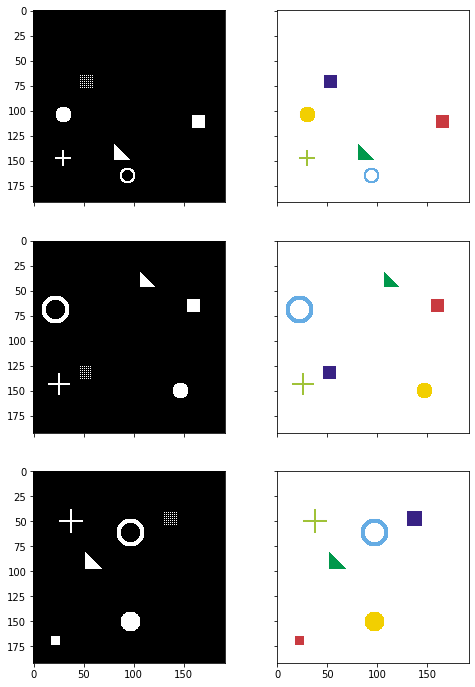

In [1]:
import utils.simulation as simulation
import numpy as np
import utils.helper as helper
import matplotlib.pyplot as plt

# Generate some random images
input_images, target_masks = simulation.generate_random_data(192, 192, count=3)

for x in [input_images, target_masks]:
    print(x.shape)
    print(x.min(), x.max())

# change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]

# map each channels (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in target_masks]

# left: input iamge, rigth: target mask (ground-truth)
helper.plot_side_by_side([input_images_rgb, target_masks_rgb])


In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        super().__init__()

        self.input_images, self.target_masks = simulation.generate_random_data(
            192, 192, count=count)
        self.transform = transform

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, index):
        image = self.input_images[index]
        mask = self.target_masks[index]

        if self.transform:
            image = self.transform(image)

        return [image, mask]

# use same transform for train/val for this example 
trans = transforms.Compose([
    transforms.ToTensor(),
])

train_set = SimDataset(2000, transform=trans)
val_set = SimDataset(200, transform=trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 25

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 2000, 'val': 200}

torch.Size([25, 3, 192, 192]) torch.Size([25, 6, 192, 192])
0.0 1.0 0.022065973 0.14689814
0.0 1.0 0.0045996094 0.06766432


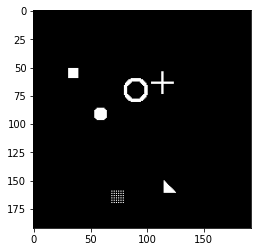

In [3]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1,2,0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

# get a batch of training data 
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

plt.imshow(reverse_transform(inputs[0]))

In [4]:
from torchinfo import summary
import torch 
from models.U_Net import UNet

unet = UNet(6).cuda()

summary(unet, input_size=(15, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     --                        --
├─Sequential: 1-1                        [15, 64, 224, 224]        --
│    └─Conv2d: 2-1                       [15, 64, 224, 224]        1,792
│    └─ReLU: 2-2                         [15, 64, 224, 224]        --
│    └─Conv2d: 2-3                       [15, 64, 224, 224]        36,928
│    └─ReLU: 2-4                         [15, 64, 224, 224]        --
├─MaxPool2d: 1-2                         [15, 64, 112, 112]        --
├─Sequential: 1-3                        [15, 128, 112, 112]       --
│    └─Conv2d: 2-5                       [15, 128, 112, 112]       73,856
│    └─ReLU: 2-6                         [15, 128, 112, 112]       --
│    └─Conv2d: 2-7                       [15, 128, 112, 112]       147,584
│    └─ReLU: 2-8                         [15, 128, 112, 112]       --
├─MaxPool2d: 1-4                         [15, 128, 56, 56]         --

In [6]:
from collections import defaultdict
import torch.nn.functional as F

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ",".join(outputs)))



In [8]:
import copy
import time
from utils.utils import *

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # each epoch has a training and validation phase 
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print('LR', param_group['lr'])

                model.train()
            else:
                model.eval()

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = tensor2var(inputs)
                labels = tensor2var(labels)

                # zero the parameter gradients 
                optimizer.zero_grad()

                # forward
                # track history if only in train 
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase 
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics 
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model 
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since 
        print('{:.0f}m {:0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights 
    model.load_state_dict(best_model_wts)
    
    return model




In [9]:
import torch 
import torch.optim as optim
from torch.optim import lr_scheduler

num_class = 6

model = UNet(num_class).cuda()

# observe that all parameters are being optimzied 
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1, verbose=True)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=40)


Epoch 0/39
----------
LR 0.0001


/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train: bce: 0.203288,dice: 0.994427,loss: 0.598857
val: bce: 0.029362,dice: 0.985713,loss: 0.507538
saving best model
0m 17.936149s
Epoch 1/39
----------
LR 0.0001
train: bce: 0.023782,dice: 0.825897,loss: 0.424839
val: bce: 0.027224,dice: 0.710814,loss: 0.369019
saving best model
0m 26.319168s
Epoch 2/39
----------
LR 0.0001
train: bce: 0.025007,dice: 0.622507,loss: 0.323757
val: bce: 0.017296,dice: 0.527013,loss: 0.272154
saving best model
0m 28.120722s
Epoch 3/39
----------
LR 0.0001
train: bce: 0.017054,dice: 0.441638,loss: 0.229346
val: bce: 0.016114,dice: 0.359444,loss: 0.187779
saving best model
0m 16.224499s
Epoch 4/39
----------
LR 0.0001
train: bce: 0.014736,dice: 0.339544,loss: 0.177140
val: bce: 0.014071,dice: 0.341926,loss: 0.177998
saving best model
0m 28.125076s
Epoch 5/39
----------
LR 0.0001
train: bce: 0.013900,dice: 0.288982,loss: 0.151441
val: bce: 0.012702,dice: 0.234751,loss: 0.123727
saving best model
0m 26.138405s
Epoch 6/39
----------
LR 0.0001
train: bce: 0.01

torch.Size([3, 6, 192, 192])


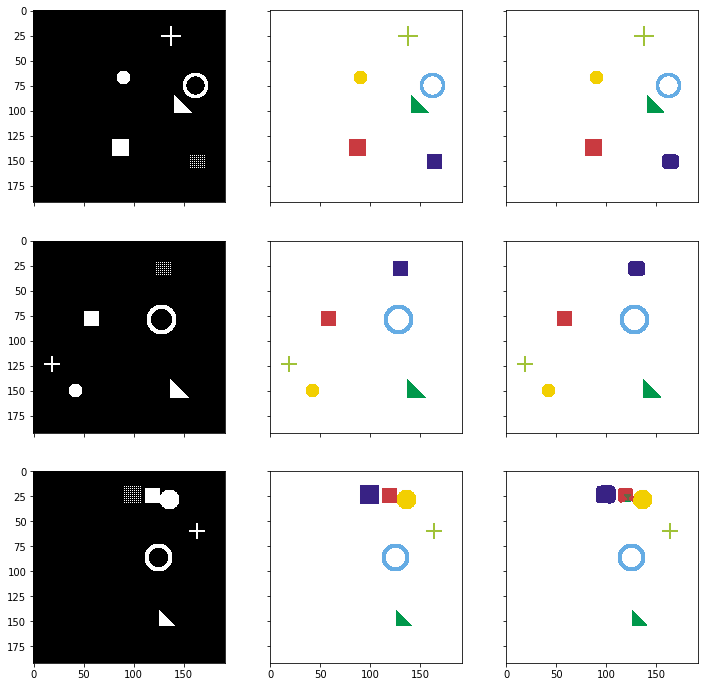

In [18]:
# prediction 

model.eval() # set model to evaluate mode 

test_dataset = SimDataset(3, transform=trans)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)

inputs, labels = next(iter(test_loader))
inputs = tensor2var(inputs)
labels = tensor2var(labels)

pred = model(inputs)
print(pred.shape)

# change channel-order and make 3 channels for matplot 
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color 
target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu()]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred.cpu()]

helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])
